# Trading strategy exploration and backtesting project with Python 3 

##  Load data 

In [1]:
import sys
import numpy as np
import pandas as pd

!{sys.executable} -m pip install --user matplotlib
import matplotlib.pyplot as plt

!{sys.executable} -m pip install --user seaborn
import seaborn as sns
#%matplotlib inline

In [2]:
file_path = sys.path[0]
file_path

'/Users/liaobofei/Desktop/trading-strategy-explorer'

In [3]:
PATH_QQQ = "/data/QQQlarge.csv"

df = pd.read_csv(file_path+PATH_QQQ)


## Exploratory analysis 

In [4]:
df.head()

,Date,Close,Volume,Open,High,Low
0,4/29/24,432.75,30022160,433.13,433.76,429.9800
1,4/26/24,431.00,41874910,427.62,432.55,426.9200
2,4/25/24,424.45,57392170,419.24,425.32,418.1400
3,4/24/24,426.51,48440310,428.20,429.73,424.2000
4,4/23/24,425.07,44384740,420.77,426.28,418.8715


In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Close,251.0,3.879294e+02,3.455713e+01,3.161700e+02,3.638200e+02,377.99,4.234450e+02,446.38
Volume,251.0,4.888649e+07,1.158228e+07,1.571883e+07,4.061179e+07,47153920.00,5.542797e+07,80931970.00
Open,251.0,3.877916e+02,3.476343e+01,3.170600e+02,3.636250e+02,379.18,4.223250e+02,448.88
High,251.0,3.901803e+02,3.461094e+01,3.182300e+02,3.661850e+02,379.99,4.250238e+02,449.34
Low,251.0,3.853455e+02,3.451429e+01,3.151150e+02,3.608013e+02,375.72,4.197208e+02,445.67


In [6]:
cols = [i for i in list(df.columns)]
print(cols)

['Date', 'Close', 'Volume', 'Open', 'High', 'Low']


In [7]:
df.isna().sum() 

Date      0
Close     0
Volume    0
Open      0
High      0
Low       0
dtype: int64


## QQQ Data Preprocessing

In [8]:
def QQQpreprocessing(df):
    df2 = df.copy()
    #We have daily candle, so we can remove, hours, minutes and seconds from our data
    df2['Date']=df2['Date'].apply(lambda x: str(x).replace('00:00:00',''))
    df2 = df2.set_index('Date')
    df2 = df2.sort_values(['Date']) # sort by date
    df3 = df2.copy()
    return df3


In [9]:
df_price = QQQpreprocessing(df)

#df_price = df.copy() # OR

df_price.head(5)
df_price.tail(5)

,Close,Volume,Open,High,Low
Date,,,,,
9/29/23,358.27,64829620,361.54,362.9500,357.02
9/5/23,378.07,32344220,376.77,379.3093,375.83
9/6/23,374.74,42998740,377.28,377.6300,372.70
9/7/23,372.06,52060720,370.21,372.8500,369.15
9/8/23,372.58,35847360,372.01,374.8500,371.60


My first value is the last one in time order, so I have to reorder my dataset.


## Plot data

In [10]:
import matplotlib.ticker as ticker
def plot_time_series(df, Y):
    sns.set_theme(style="darkgrid")
    sns.set(rc={"figure.figsize":(25, 20)})
    # build the figure
    fig, ax = plt.subplots()
    sns.lineplot(data=df, x=df.index , y=Y)
    
    # assign locator and formatter for the xaxis ticks.
    tick_spacing=20
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # put the labels at 45deg since they tend to be too long
    fig.autofmt_xdate()
    plt.show()


/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


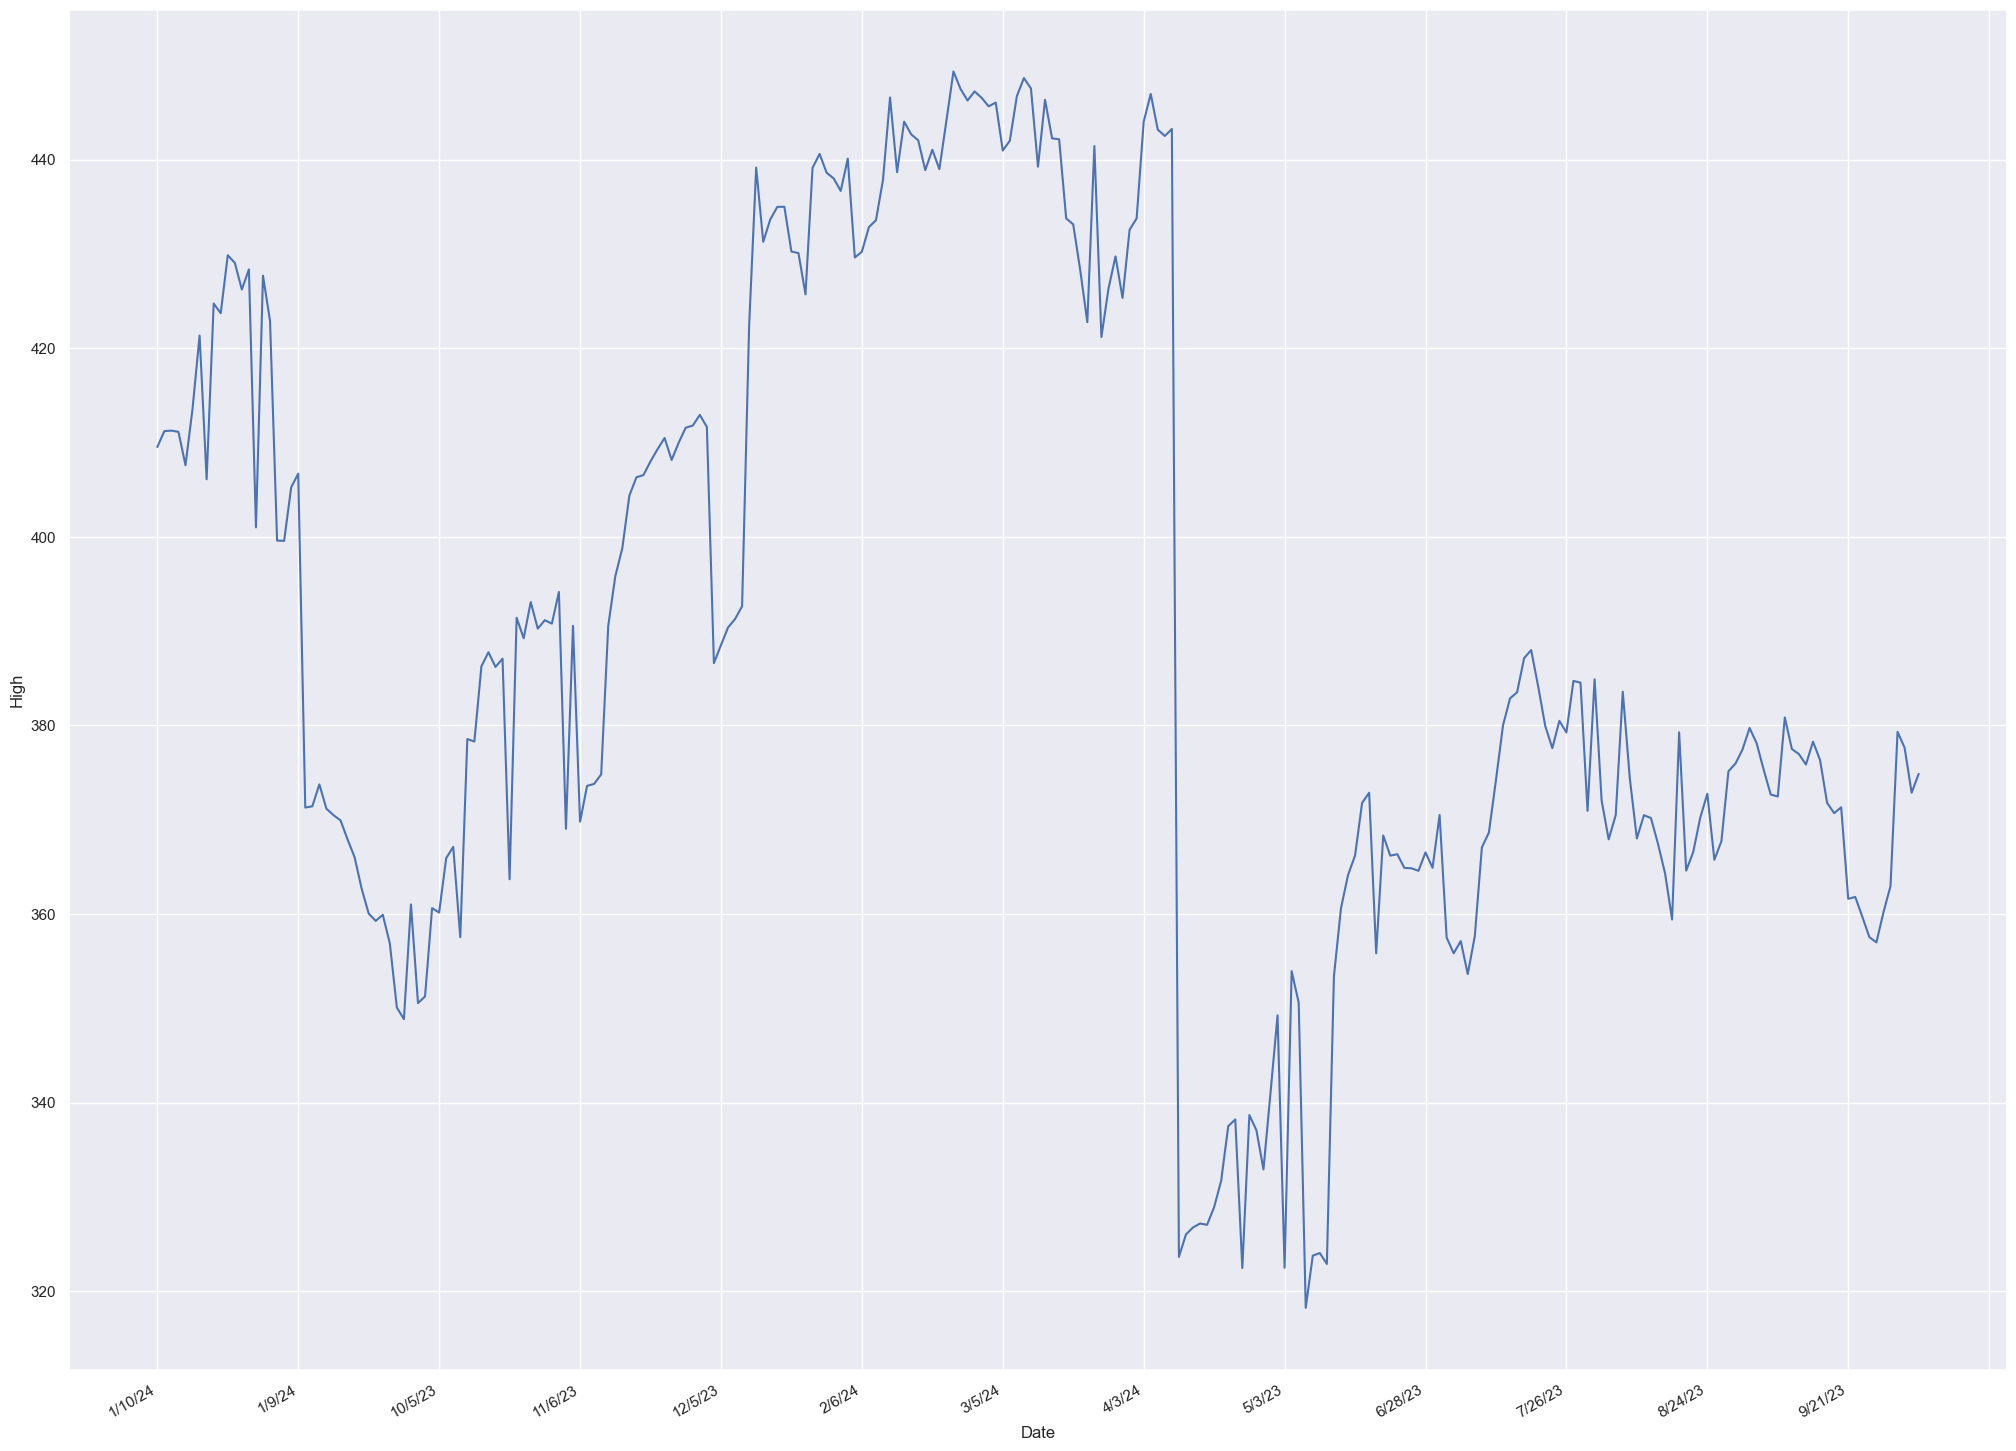

In [11]:
plot_time_series(df_price,'High')

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


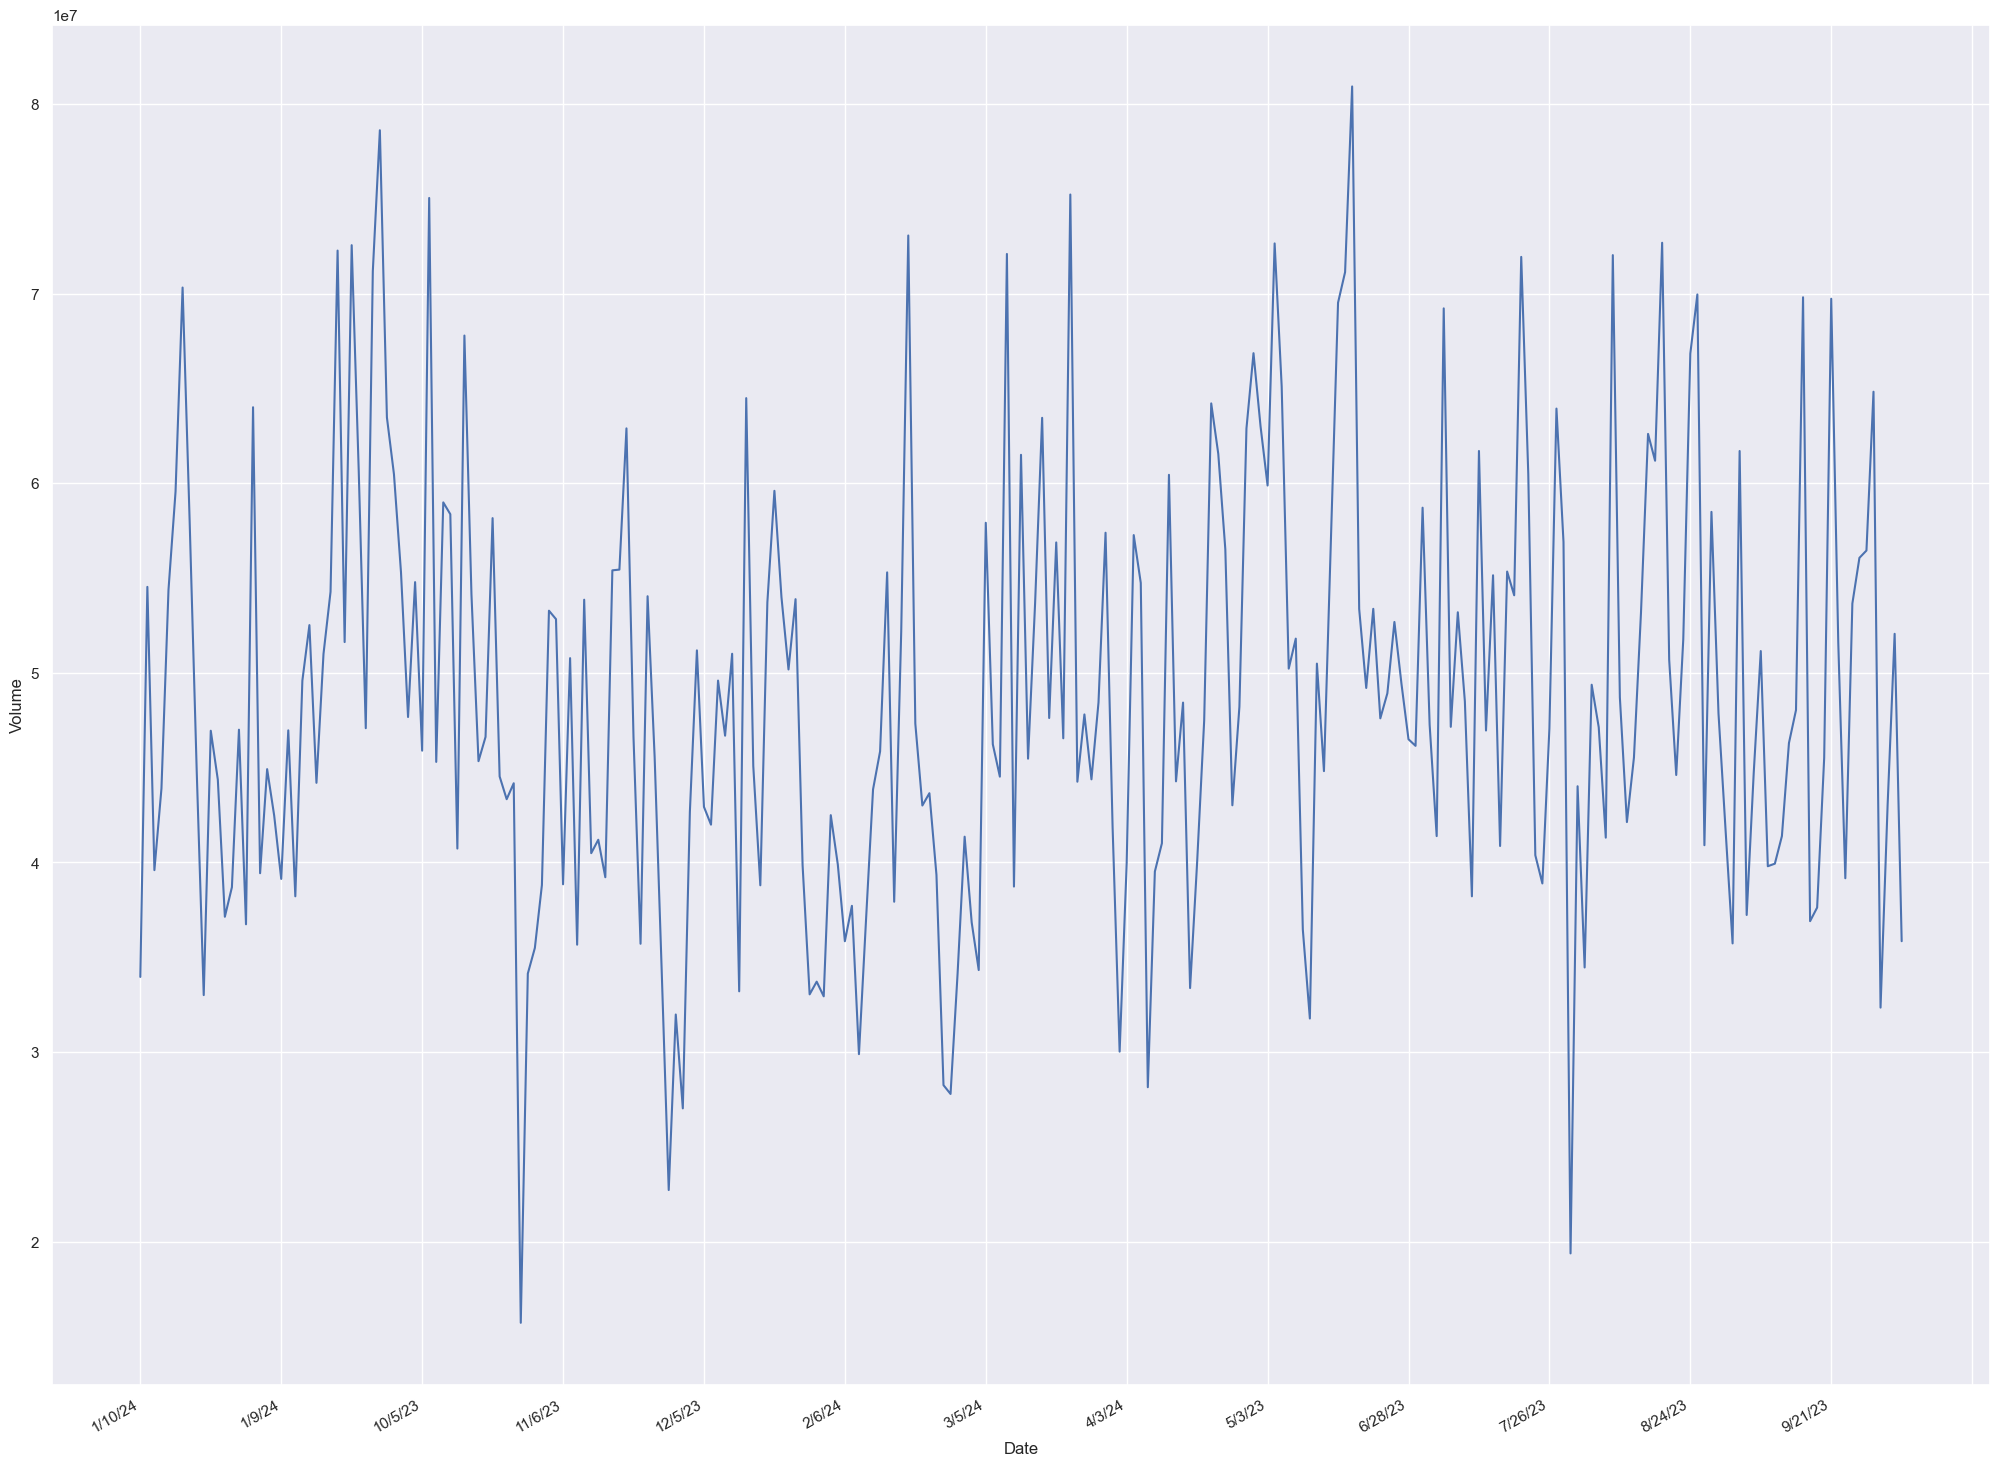

In [12]:
plot_time_series(df_price,'Volume')

## Backtesting


OPEN LONG position  |  1/26/24  open operation price : 423.81

OPEN LONG position  |  1/3/24  open operation price : 398.33

OPEN LONG position  |  1/4/24  open operation price : 396.28

OPEN LONG position  |  10/10/23  open operation price : 368.59

OPEN LONG position  |  10/13/23  open operation price : 365.28

OPEN LONG position  |  10/18/23  open operation price : 363.37

OPEN LONG position  |  10/2/23  open operation price : 361.26

OPEN LONG position  |  10/23/23  open operation price : 355.67

OPEN LONG position  |  10/25/23  open operation price : 350.34

OPEN LONG position  |  10/27/23  open operation price : 345.31

OPEN LONG position  |  10/31/23  open operation price : 350.87

OPEN LONG position  |  11/1/23  open operation price : 356.96

OPEN LONG position  |  11/2/23  open operation price : 363.44

OPEN LONG position  |  11/22/23  open operation price : 390.06

OPEN LONG position  |  11/27/23  open operation price : 389.17

OPEN LONG position  |  11/3/23  open operation 

/var/folders/vg/bhspxhys62sg4rcnvltrbvx80000gn/T/ipykernel_26977/4243822558.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['open_signal'].iloc[idx] = Close
/var/folders/vg/bhspxhys62sg4rcnvltrbvx80000gn/T/ipykernel_26977/4243822558.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['close_signal'].iloc[idx] = Close
/var/folders/vg/bhspxhys62sg4rcnvltrbvx80000gn/T/ipykernel_26977/4243822558.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

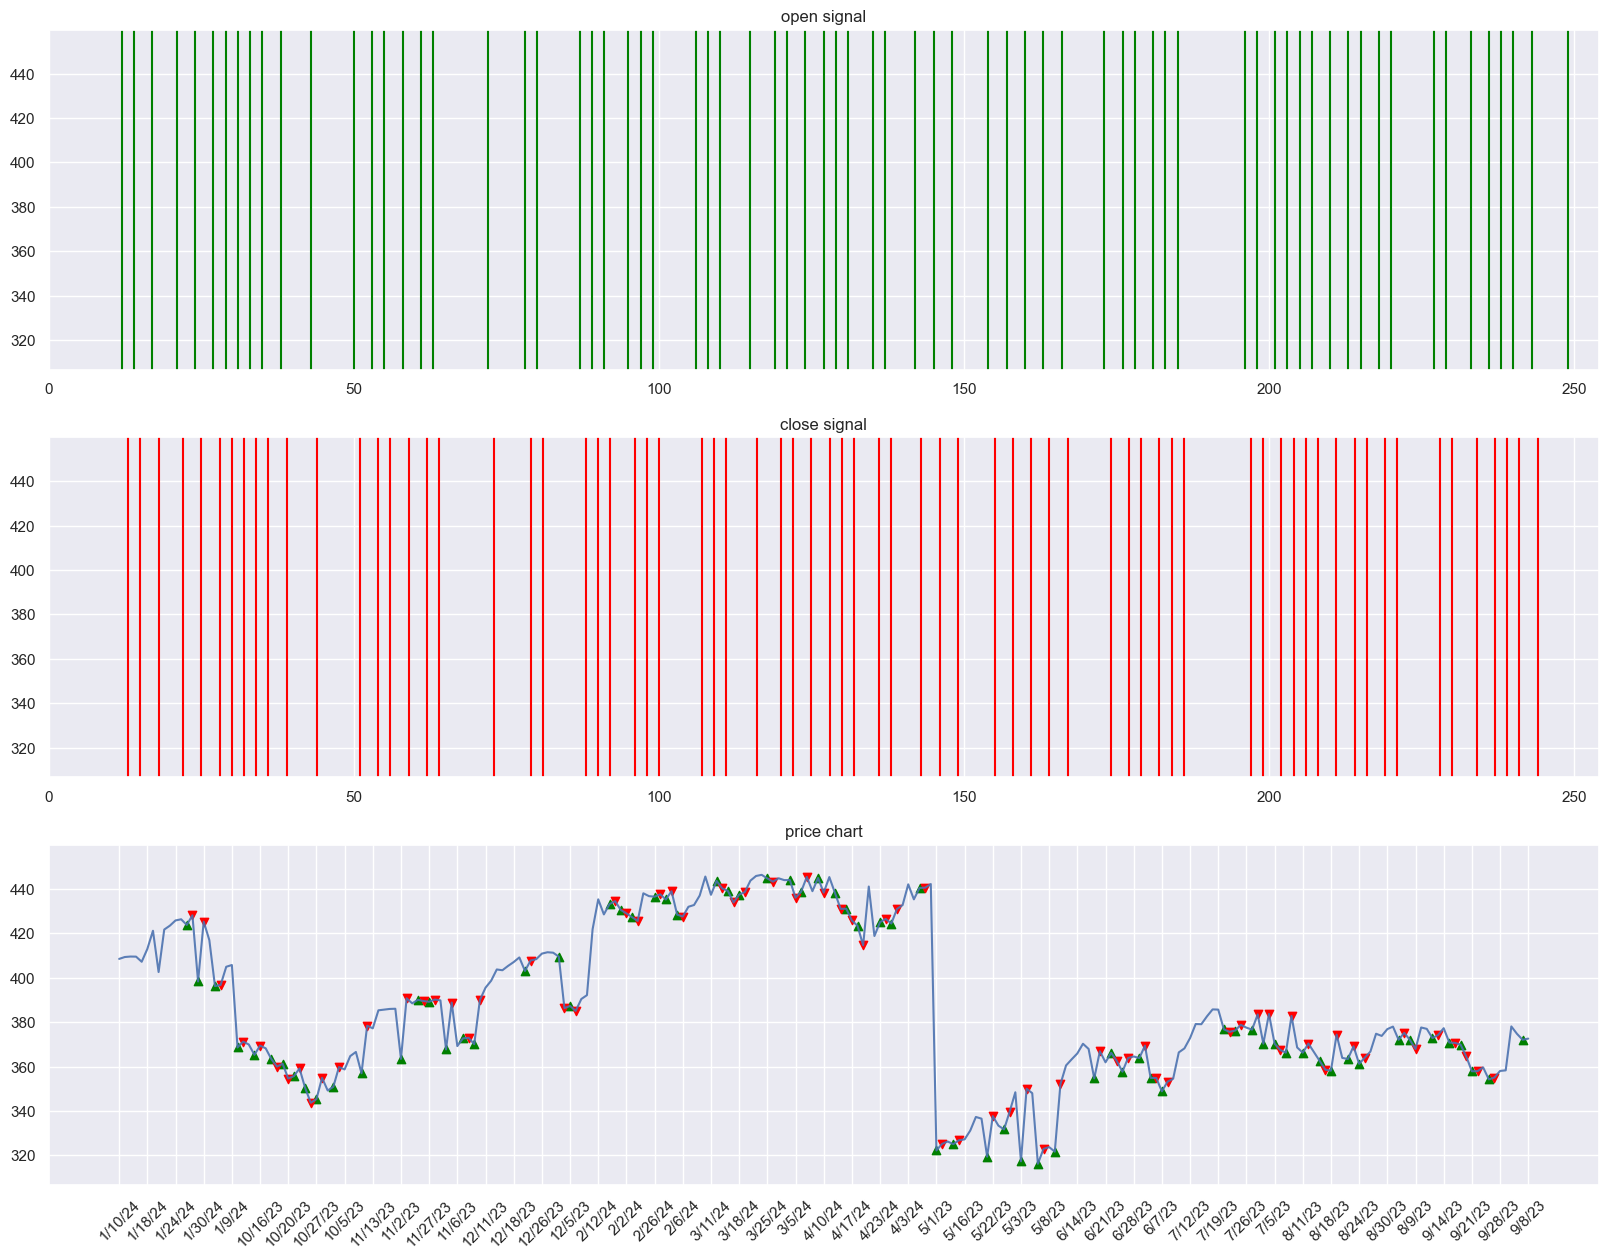

<Figure size 2500x2000 with 0 Axes>

[1000000, 1000000, 1085999999.9999938, 1085999999.9999938, 7323440999999.966, 7323440999999.966, 7323440999999.966, 867827758500045.9, 867827758500045.9, 867827758500045.9, 867827758500045.9, 5.714645789722915e+17, 5.714645789722915e+17, 5.714645789722915e+17, 5.906086423678707e+20, 5.906086423678707e+20, 5.906086423678707e+20, -5.0142673737031894e+23, -5.0142673737031894e+23, 8.343740909842068e+26, 8.343740909842068e+26, 7.22567962792319e+29, 7.22567962792319e+29, -1.2059659299003714e+33, -1.2059659299003714e+33, -2.8985391125155466e+36, -2.8985391125155466e+36, -2.8985391125155466e+36, -6.437655368897027e+39, -6.437655368897027e+39, -6.437655368897027e+39, -6.437655368897027e+39, -6.437655368897027e+39, -3.449617629423473e+43, -3.449617629423473e+43, -3.449617629423473e+43, -3.449617629423473e+43, -3.449617629423473e+43, -3.449617629423473e+43, -3.449617629423473e+43, -2.3547089938444634e+47, -2.3547089938444634e+47, -2.3547089938444634e+47, 3.2141777765977593e+49, 3.2141777765977593

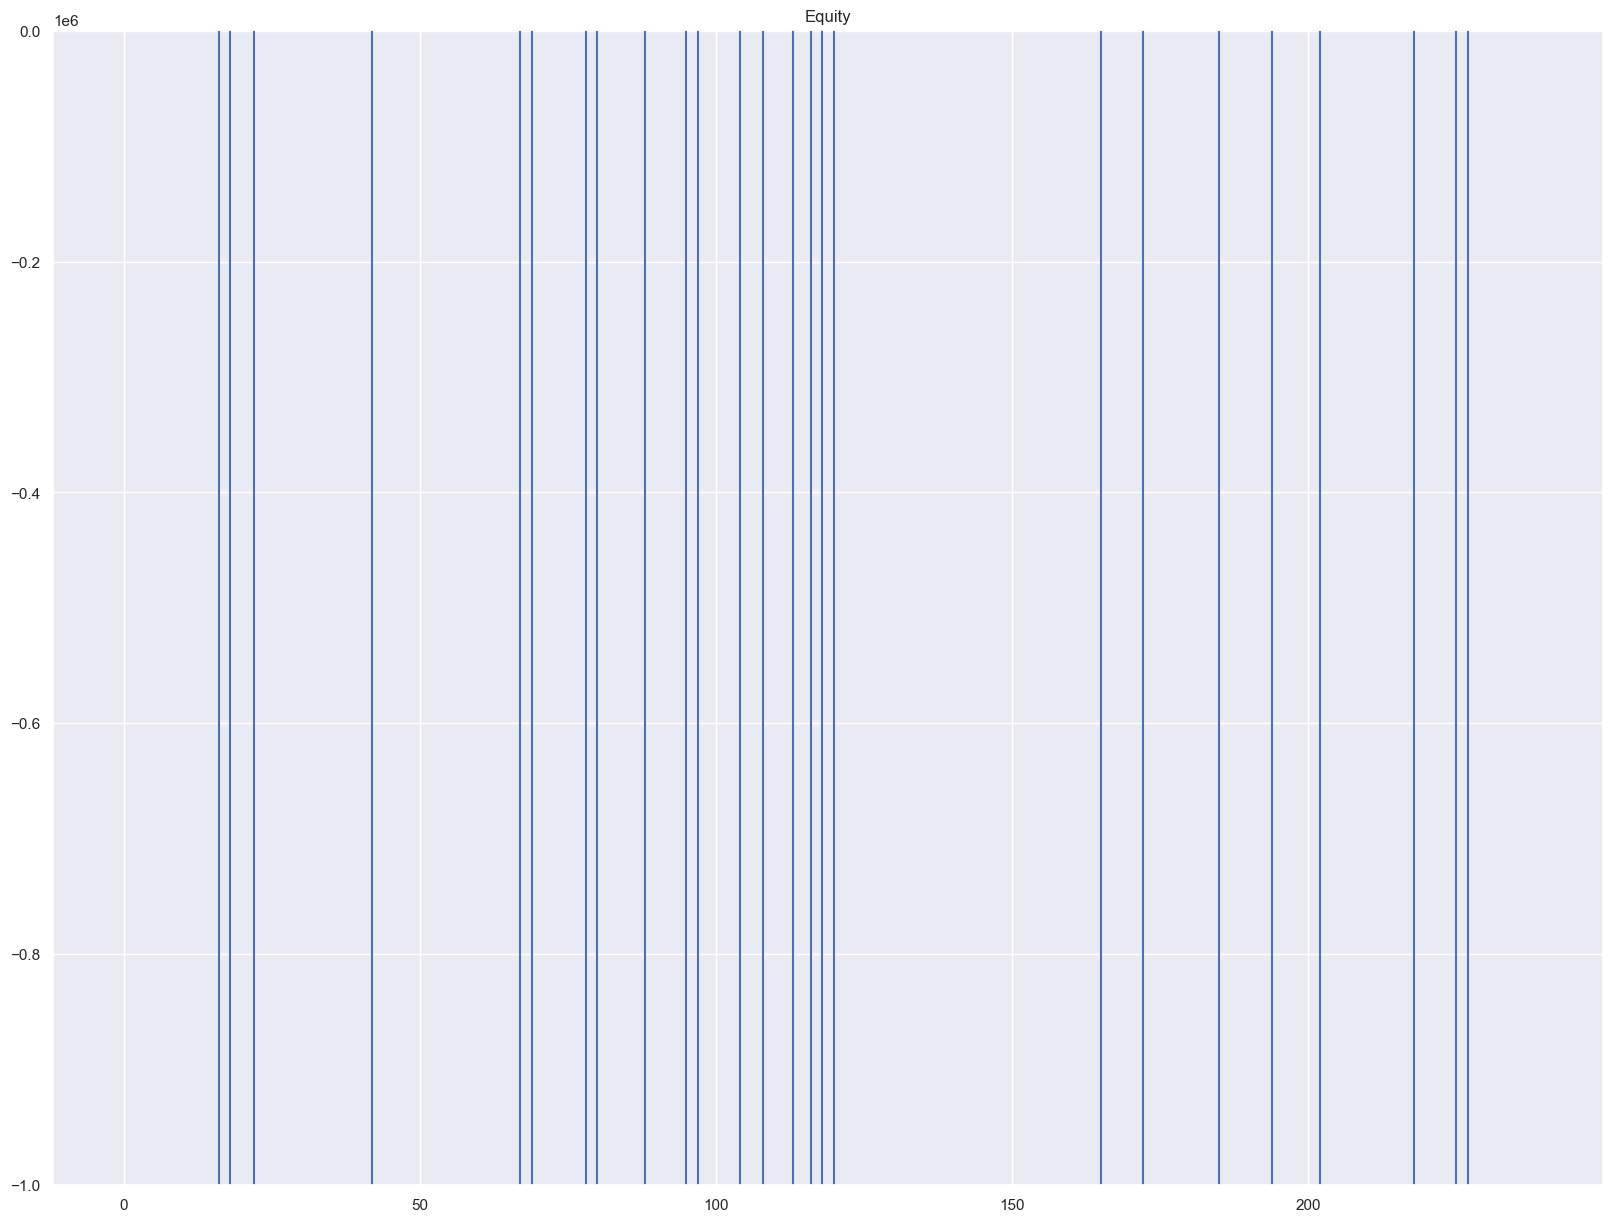

In [26]:
take_profit = 0.005 # % take profit
stop_loss = 0.004 # % stop loss
cap = 1000000  # capital
laverage = 250 # laverage

def backtest(df, capital):
    initial_capital = capital
    plot_open_signal=[] # open signal
    plot_close_signal=[] # close signal
    equity_history=[]
    open_operation = False
    buffer_period=10
    df['open_signal'] = np.nan #pd.DataFrame(np.nan, index=range(len(df['close'])))#, columns=['A', 'B'])
    df['close_signal'] = np.nan
    
    for idx in range(len(df)):
        Date = df.index[idx]
        Open = df['Open'].iloc[idx]
        High = df['High'].iloc[idx]
        Low  = df['Low'].iloc[idx]
        Close  = df['Close'].iloc[idx]
        
        if int(idx) > buffer_period and int(idx) < len(df.values)-1:  # buffer
            
            if open_operation==False and Close < df['Close'].iloc[idx-2]:
                open_operation = True
                open_price = Close
                print('\nOPEN LONG position  | ',Date,' open operation price :',round(Close,8))
                plot_open_signal.append(idx)
                df['open_signal'].iloc[idx] = Close
                
            actual_price = Close
                                
            if open_operation == True:
                gain = (actual_price - open_price) * capital * laverage
                real_TP = take_profit * initial_capital
                real_SL = -stop_loss * initial_capital

                if gain >= real_TP or gain <= real_SL:
                    capital += gain
                    open_operation = False
                    plot_close_signal.append(idx)
                    df['close_signal'].iloc[idx] = Close

            equity_history.append(capital)
    
    
    
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)
    f.set_figheight(15)
    f.set_figwidth(20)


    
    # OPEN SIGNAL
    ax1.vlines(plot_open_signal,ymin=0,ymax=1000,colors='green')
    ax1.set_title('open signal')

    ax1.set_ylim(0, 1)
    ax1.set_xlim(0,max(plot_open_signal)+5)
    x_axis1 = ax1.axes.get_xaxis()
    x_axis1.set_visible(True)
    y_axis1 = ax1.axes.get_yaxis()
    y_axis1.set_visible(True)
    
    
    # CLOSE SIGNAL
    ax2.vlines(plot_close_signal,ymin=0,ymax=1000,colors='red')
    ax2.set_title('close signal')
    x_axis2 = ax2.axes.get_xaxis()    
    x_axis2.set_visible(True)
    y_axis2 = ax2.axes.get_yaxis()
    y_axis2.set_visible(True)
    ax2.set_ylim(0, 1)
    ax2.set_xlim(0,max(plot_open_signal)+5)

    
    # PRICES
    ax3.plot(df.index, df.Close,alpha=0.9)
    ax3.scatter(df.index,df['open_signal'], color='green', label='buy',marker='^',alpha=1 )
    ax3.scatter(df.index,df['close_signal'], color='red', label='sell' ,marker='v',alpha=1 )
    
    ax3.set_title('price chart')
    ax3.set_xticks(df.index[::5])
    ax3.set_xticklabels(df.index[::5], rotation=45)
    ax3.set_ylim(min(df.Close)*0.97, max(df.Close)*1.03)
    plt.savefig("img/open.png")

    plt.figure(figsize=(25,20))
    plt.show()
    print(equity_history)
    return equity_history                    


def plot_equity(equity_history):
    f, ax1 = plt.subplots(1, 1, sharey=True)
    f.set_figheight(15)
    f.set_figwidth(20)
    
    plt.plot(equity_history)
    
    plt.ylim(-1000000,1000)
    plt.title('Equity')
    plt.savefig("img/figure.png")
    plt.show()
    
equity = backtest(df_price, cap)
plot_equity(equity)
